In [1]:
import os
import sys
sys.path.append('../python')

import pandas as pd
import numpy as np
import yaml
import time
import json
import ast
import pickle
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from matplotlib import pyplot as plt

import api
import data_tools
import text_tools

rng = np.random.default_rng(20241025)

namespace = 'la_planning_dept_cases'
embeddings_filename = 'temp-embeddings-2024-10-25.pkl'

In [2]:
df = data_tools.get_la_planning_dept_cases()
texts = list(df['text'])

In [3]:
df['Percent Affordable'] = df['Affordable Adding']/df['Total Adding']
df['Percent Affordable'] = df['Percent Affordable'].fillna(0)

In [4]:
if os.path.exists(embeddings_filename):
    with open(embeddings_filename, 'rb') as f:
        embeddings = pickle.load(f)
else:
    %time embeddings = api.get_embeddings(texts, namespace=namespace)
    with open(embeddings_filename, 'wb') as f:
        pickle.dump(embeddings, f) 

In [5]:
X = np.array(embeddings)

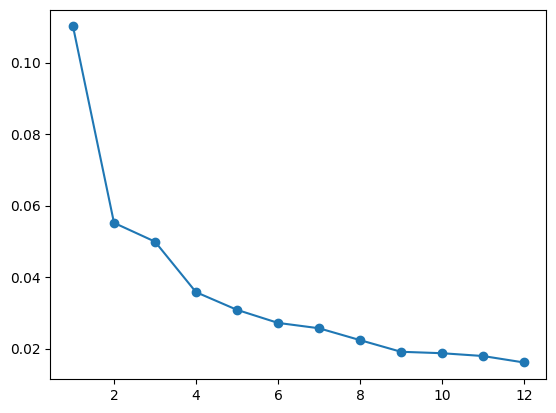

In [6]:
# Scree plot to show first 12 principal components
pca = PCA(n_components=12)
pca.fit(X)
plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_ratio_, 'o-')
plt.show()

In [7]:
# new PCA with 9 components
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X)
pca_colnames = []
for i in np.arange(9):
    colname = f'pca{i}'
    df[colname] = X_pca[:,i]
    pca_colnames.append(colname)
for col in pca_colnames:
    assert df[colname].isna().sum()==0

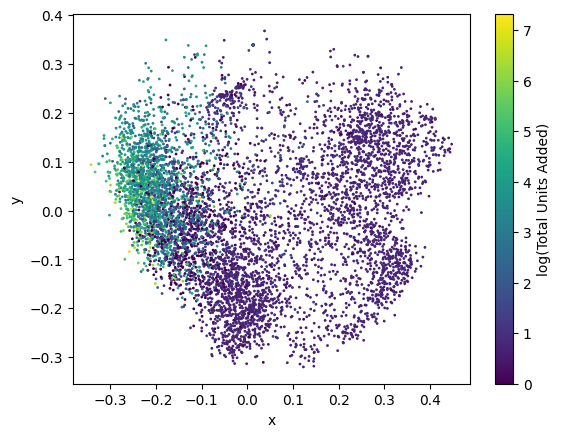

In [8]:
c = np.log(1+df['Total Adding'])
alpha = 0.1 + 0.9*(c - c.min())/(c.max() - c.min())
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=c, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Total Units Added)')
plt.show()

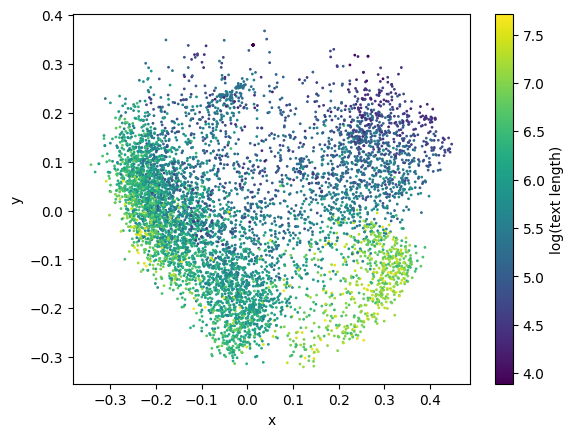

In [9]:
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=np.log(df['text'].str.len()), s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(text length)')
plt.show()

In [10]:
df['Days to Complete'] = (df['Completion Date'] - df['Filed Date'])/pd.to_timedelta(1,unit='D')

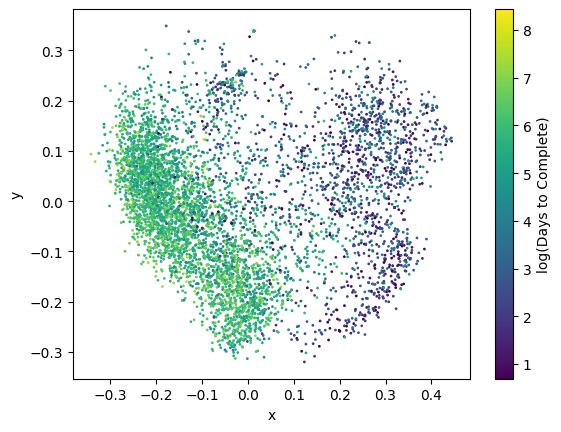

In [11]:
idx = df['Days to Complete']>0
plt.scatter(x=X_pca[idx,0], y=X_pca[idx,1], c=np.log(1+df.loc[idx,'Days to Complete']), s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Days to Complete)')
plt.show()

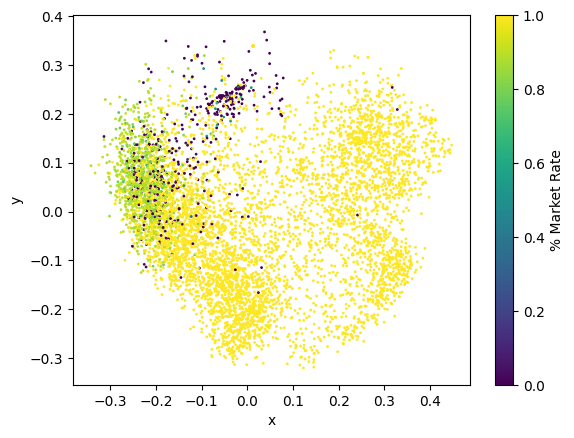

In [12]:
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=1-df['% Affordable Adding'], s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='% Market Rate')
plt.show()

In [13]:
y = df['Case Action']=='APPROVED'
y.value_counts()

Case Action
False    3337
True     3250
Name: count, dtype: int64

In [14]:
df_train, df_test, y_train, y_test = train_test_split(
    df, y, test_size=0.33, random_state=1236
)

In [15]:
# accuracy score with only text
column_transformer = ColumnTransformer([
    ('pca_components', 'passthrough', pca_colnames)
])
pipeline = Pipeline([
    ('column_transformer', column_transformer),
    ('classifier', xgb.XGBClassifier())
])
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict(df_test)
accuracy_score(y_test, y_pred)


0.8707451701931923

In [16]:
# accuracy score with only hard information
numeric_cols = ['Total Adding', 'NonRes Adding', 'Percent Affordable']
categorical_cols = ['Council District']
column_transformer = ColumnTransformer([
    ('numeric_variables', StandardScaler(), numeric_cols),
    ('categorical_variables', OneHotEncoder(), categorical_cols)
])
pipeline = Pipeline([
    ('column_transformer', column_transformer),
    ('classifier', xgb.XGBClassifier())
])
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict(df_test)
accuracy_score(y_test, y_pred)


0.7548298068077277

In [17]:
# accuracy score with text and other hard data

column_transformer = ColumnTransformer([
    ('pca_components', 'passthrough', pca_colnames),
    ('numeric_variables', StandardScaler(), numeric_cols),
    ('categorical_variables', OneHotEncoder(), categorical_cols)
])
pipeline = Pipeline([
    ('column_transformer', column_transformer),
    ('classifier', xgb.XGBClassifier())
])
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict(df_test)
accuracy_score(y_test, y_pred)


0.8712051517939282

In [21]:
recall_score(y_test, y_pred)

0.8407163053722903